In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('petfinder.csv')
df = df[df.Type == 'Dog'] 
df.drop(columns='Type', inplace=True)
cat_cols = df.columns[df.dtypes == 'object']
num_cols = df.columns[(~(df.dtypes == 'object')) & (df.columns != 'Adoption')]
print('Shape:', df.shape)
print('cat_cols:', list(cat_cols))
print('num_cols', list(num_cols))
label = 'Adoption'
ohe_df = df.copy(deep=True)

Shape: (10232, 18)
cat_cols: ['Name', 'Breed2', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'State', 'Description']
num_cols ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']


In [3]:
df.head(10)

,Name,Age,Breed2,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,Adoption
2,yes,1,Mixed Breed,Male,Brown,Medium,Medium,Yes,Yes,No,Healthy,1,0,Selangor,0,yes,7.0,1
3,yes,4,Mixed Breed,Female,Black,Medium,Short,Yes,Yes,No,Healthy,1,150,Kuala Lumpur,0,yes,8.0,1
4,yes,1,Mixed Breed,Male,Black,Medium,Short,No,No,No,Healthy,1,0,Selangor,0,yes,3.0,1
7,yes,0,Mixed Breed,Female,Black,Medium,Short,No,No,No,Healthy,6,0,Selangor,0,yes,9.0,1
10,yes,2,Mixed Breed,Male,Black,Medium,Short,No,Yes,No,Healthy,1,0,Kuala Lumpur,0,yes,7.0,1
12,yes,2,Mixed Breed,Male,Brown,Medium,Long,Yes,Yes,No,Healthy,1,0,Selangor,0,yes,1.0,1
14,yes,3,Mixed Breed,Female,Brown,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Kuala Lumpur,0,yes,2.0,1
15,yes,78,Terrier,Male,Black,Medium,Medium,Not Sure,Not Sure,Not Sure,Healthy,1,0,Selangor,0,yes,2.0,0
17,yes,8,Mixed Breed,Female,Brown,Medium,Short,No,Yes,Yes,Healthy,1,10,Perak,0,yes,2.0,0
18,yes,2,Mixed Breed,Female,Black,Medium,Short,No,Yes,No,Healthy,1,0,Kuala Lumpur,0,yes,8.0,1


In [4]:
df.shape

(10232, 18)

In [5]:
df.nunique().to_frame().T

,Name,Age,Breed2,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,Adoption
0,2,106,124,3,7,4,3,3,3,3,3,19,67,14,9,2,31,2


In [6]:
pd.Series({col: df[col].unique() for col in df[cat_cols]})

Name                                                    [yes, no]
Breed2          [Mixed Breed, Terrier, Rottweiler, Shih Tzu, J...
Gender                                      [Male, Female, Mixed]
Color1          [Brown, Black, Gray, Cream, White, Golden, Yel...
MaturitySize                  [Medium, Large, Small, Extra Large]
FurLength                                   [Medium, Short, Long]
Vaccinated                                    [Yes, No, Not Sure]
Dewormed                                      [Yes, No, Not Sure]
Sterilized                                    [No, Not Sure, Yes]
Health                    [Healthy, Minor Injury, Serious Injury]
State           [Selangor, Kuala Lumpur, Perak, Johor, Pulau P...
Description                                             [yes, no]
dtype: object

In [7]:
df[label].value_counts()

1    5718
0    4514
Name: Adoption, dtype: int64

In [8]:
df[label].value_counts() / df.shape[0]

1    0.558835
0    0.441165
Name: Adoption, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=label), df[label], test_size=0.3, random_state=37, stratify=df[label])

#### Standard Scaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

num_X_train = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
num_X_test = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

In [11]:
train = pd.concat([num_X_train, X_train[cat_cols], y_train], axis=1)
test = pd.concat([num_X_test, X_test[cat_cols], y_test], axis=1)

In [12]:
weights =dict((1 / y_train.value_counts()) * (len(y_train) * 2))
print(weights)

{1: 3.5792103948025984, 0: 4.5329113924050635}


### Model with embeddings

In [13]:
cat_dims = [int(df[col].nunique()) for col in cat_cols]
emb_dims = [min(50, (x + 1) // 2) for x in cat_dims]

#### Create Dataset

In [14]:
def df_to_dataset(df, target, shuffle=True, batch_size=128):
    df = df.copy()
    label = df.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), label))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

#### Create input dtypes

In [15]:
def get_tf_dtypes(train, target):
    dtypes = train.dtypes.to_dict()
    colnames = dtypes.keys()
    return {k:tf.as_dtype(v) for k, v in dtypes.items() if k not in target}

In [16]:
train_ds = df_to_dataset(train, label, batch_size=64)
val_ds = df_to_dataset(test, label, batch_size=64)

In [17]:
tf_dtypes = get_tf_dtypes(train, label)

#### Build DenseFeatures layer

In [18]:
feature_columns = []
for col in num_cols:
    print(col)
    feature_columns.append(feature_column.numeric_column(col))

Age
Quantity
Fee
VideoAmt
PhotoAmt


In [19]:
for col, dim in zip(cat_cols, emb_dims):
    print(dim,'-',col)
    col2emb = feature_column.categorical_column_with_vocabulary_list(
                                  col, df[col].unique())
    emb_col = feature_column.embedding_column(col2emb, dimension=dim)
feature_columns.append(emb_col)

1 - Name
50 - Breed2
2 - Gender
4 - Color1
2 - MaturitySize
2 - FurLength
2 - Vaccinated
2 - Dewormed
2 - Sterilized
2 - Health
7 - State
1 - Description


In [20]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, name='emb')

#### Create model using Keras functional API

In [21]:
def emb_model(input_types, feature_column):

    feature_inputs = {}
    for col, dtype in input_types.items():
        feature_inputs[col] = tf.keras.Input((1,), dtype=dtype, name=col)
    
    f_col = feature_column(feature_inputs)
    x = tf.keras.layers.Dense(64, name='fc1', activation='relu')(f_col)
    x = tf.keras.layers.Dropout(0.5, name='drop1')(x)
    x = tf.keras.layers.Dense(64, name='fc2', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.8, name='drop2')(x)
    x = tf.keras.layers.Dense(1, name='pred', activation='sigmoid')(x)

    inputs = list(feature_inputs.values())
    model = tf.keras.Model(inputs=inputs, outputs=x, name='mlp_w_embeddings')
    return model

In [22]:
model = emb_model(tf_dtypes, feature_layer)

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(train_ds, validation_data=val_ds, epochs=100, verbose=0)

In [24]:
def results_to_df(results):
    hist = pd.DataFrame(results.history)
    hist['epoch'] = hist.index + 1
    return hist

In [25]:
hist = results_to_df(results)

In [26]:
def plot_learning_curves(hist, figsize=(20, 5), metrics=('accuracy', 'val_accuracy')):
    
    metric, val_metric=metrics
    fig, ax = plt.subplots(1, 2, figsize=figsize,
                           gridspec_kw=dict(width_ratios=[4, 5]))

    sns.lineplot(data=hist, x='epoch', y=metric, ax=ax[0], label=metric)
    sns.lineplot(data=hist, x='epoch', y=val_metric, ax=ax[0], label=val_metric)
    for ypos in ax[0].get_yticks():
        ax[0].axhline(ypos, color='black', alpha=0.1)
    ax[0].set_title('Training Epochs')

    zoom = hist.iloc[(hist.shape[0] // 3):hist.shape[0], :]
    sns.lineplot(data=zoom, x='epoch', y=metric, ax=ax[1], label=metric)
    sns.lineplot(data=zoom, x='epoch', y=val_metric, ax=ax[1], label=val_metric)
    for ypos in ax[1].get_yticks():
        ax[1].axhline(ypos, color='black', alpha=0.1)
    ax[1].set_title('Training Epochs - Zoomed')
    ax[1].get_legend().remove()

    sns.despine(offset=10)
    plt.show()

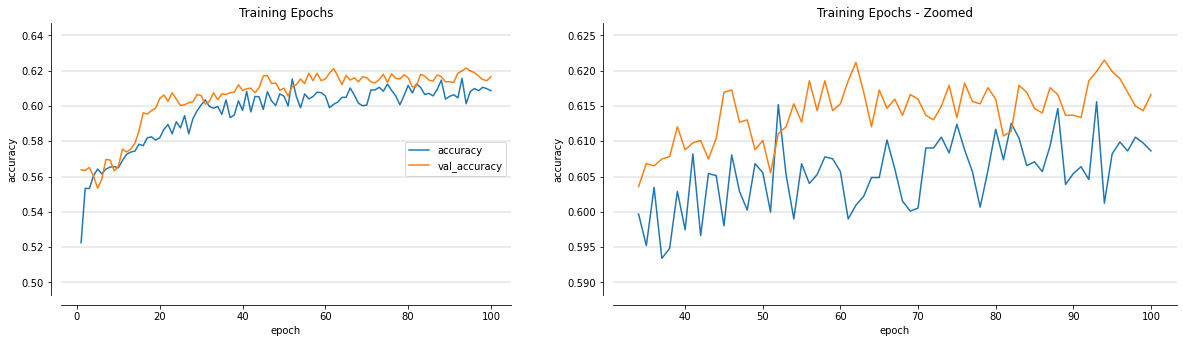

In [27]:
plot_learning_curves(hist, metrics=('accuracy', 'val_accuracy'))

In [28]:
model.summary()

Model: "mlp_w_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Description (InputLayer)        [(None, 1)]          0                                            
___________________________________________________________________________________

- It seems that by using DenseFeatures we cannot retrieve the weights of each embedding.

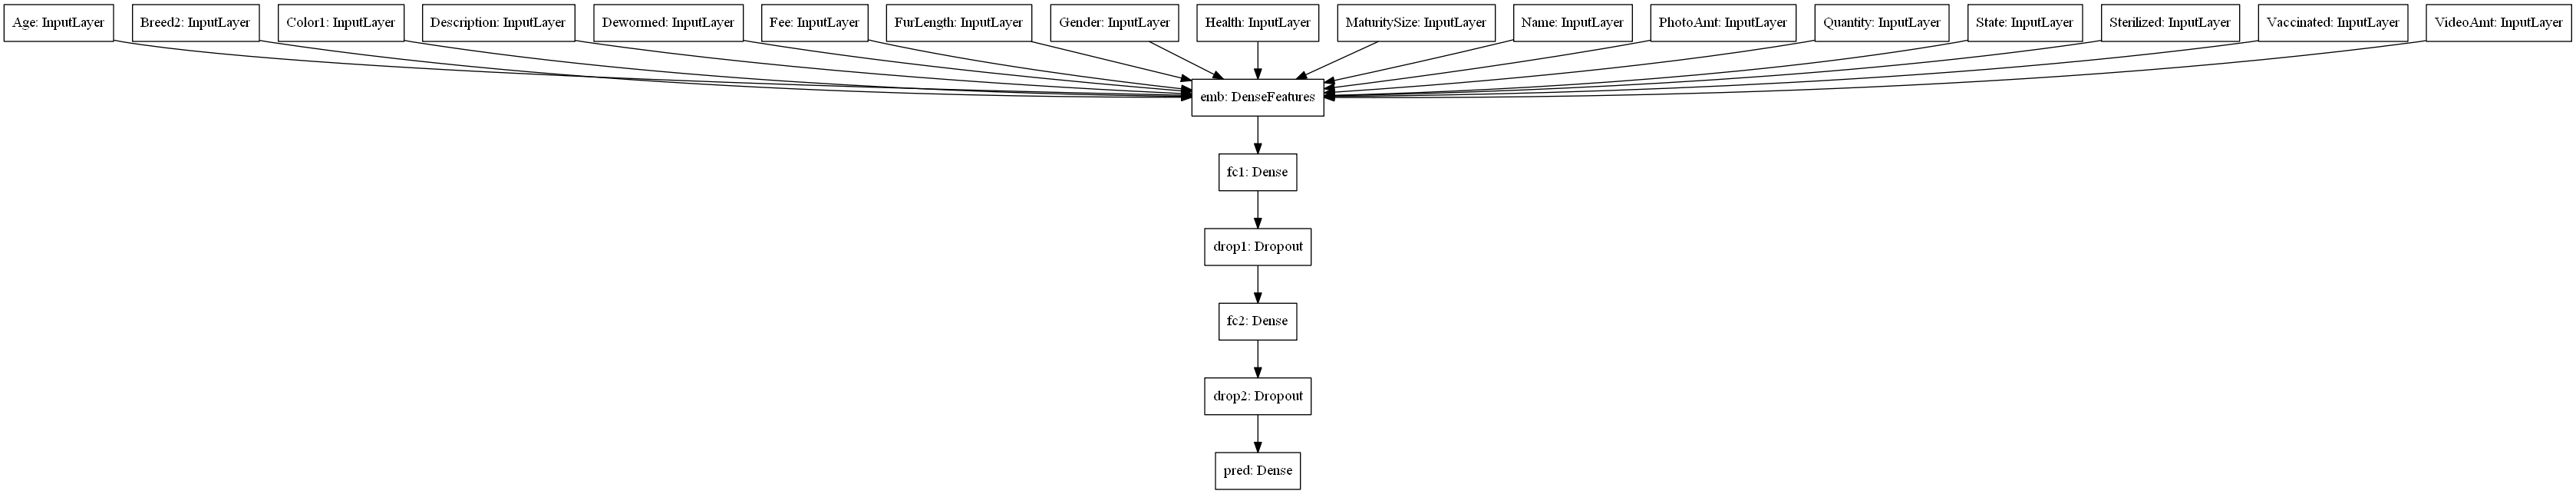

In [29]:
tf.keras.utils.plot_model(model, expand_nested=True, to_file='feature_columns.png')

In [30]:
pred_result = X_test.copy(deep=True)
pred_result['real'] = y_test
pred_result['pred'] = np.round(model.predict(val_ds)).astype(int)

In [31]:
pred_result.head()

,Name,Age,Breed2,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,Description,PhotoAmt,real,pred
13022,yes,6,German Shepherd Dog,Male,Black,Medium,Short,Yes,Yes,No,Healthy,1,0,Selangor,0,yes,1.0,1,1
804,yes,1,Mixed Breed,Female,Brown,Medium,Short,No,No,No,Healthy,2,0,Selangor,0,yes,3.0,0,1
8532,yes,2,Mixed Breed,Female,Brown,Medium,Short,Yes,Yes,No,Healthy,1,0,Selangor,0,yes,2.0,1,1
2998,no,2,Mixed Breed,Female,Black,Medium,Medium,No,No,No,Healthy,1,0,Kuala Lumpur,0,yes,2.0,1,1
11057,yes,3,Mixed Breed,Mixed,Black,Medium,Short,No,No,No,Healthy,3,0,Selangor,0,yes,3.0,0,1


In [32]:
model.evaluate(val_ds)

48/48 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6166


[0.6568679809570312, 0.6166123747825623]